<a href="https://colab.research.google.com/github/Anish7-anish/Smart-Energy-Demand-Forecaster-for-Microgrids/blob/main/Smart_Energy_Demand_Forecast_for_Microgrids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
!pip install PyWavelets
!pip install statsmodels
import pywt  # For wavelet transformations
import statsmodels.api as sm

In [120]:
data = pd.read_csv('/content/time_series_60min_singleindex.csv')

In [121]:
data.head()

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
0,2014-12-31T23:00:00Z,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01T00:00:00Z,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01T01:00:00Z,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN
3,2015-01-01T02:00:00Z,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,...,1004.79,805.0,NaN,1.04,2626.0,2810.0,3.8,NaN,NaN,NaN
4,2015-01-01T03:00:00Z,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,...,983.79,803.0,NaN,1.61,2618.0,2780.0,3.8,NaN,NaN,NaN


In [122]:
columns = data.columns.tolist()
print(len(columns))
columns

300


['utc_timestamp',
 'cet_cest_timestamp',
 'AT_load_actual_entsoe_transparency',
 'AT_load_forecast_entsoe_transparency',
 'AT_price_day_ahead',
 'AT_solar_generation_actual',
 'AT_wind_onshore_generation_actual',
 'BE_load_actual_entsoe_transparency',
 'BE_load_forecast_entsoe_transparency',
 'BE_solar_generation_actual',
 'BE_wind_generation_actual',
 'BE_wind_offshore_generation_actual',
 'BE_wind_onshore_generation_actual',
 'BG_load_actual_entsoe_transparency',
 'BG_load_forecast_entsoe_transparency',
 'BG_solar_generation_actual',
 'BG_wind_onshore_generation_actual',
 'CH_load_actual_entsoe_transparency',
 'CH_load_forecast_entsoe_transparency',
 'CH_solar_capacity',
 'CH_solar_generation_actual',
 'CH_wind_onshore_capacity',
 'CH_wind_onshore_generation_actual',
 'CY_load_actual_entsoe_transparency',
 'CY_load_forecast_entsoe_transparency',
 'CY_wind_onshore_generation_actual',
 'CZ_load_actual_entsoe_transparency',
 'CZ_load_forecast_entsoe_transparency',
 'CZ_solar_generation_

In [123]:
def load_data(csv_path):
    """
    Loads the dataset from a CSV file into a Pandas DataFrame.
    Assumes the CSV has a 'utc_timestamp' column plus demand and other features.
    """
    # 1. Parse 'utc_timestamp' into a DateTime
    df = pd.read_csv(csv_path, parse_dates=['utc_timestamp'])

    # 2. Sort by 'utc_timestamp'
    df = df.sort_values('utc_timestamp')

    # 3. Set 'utc_timestamp' as the index for time-based operations
    df.set_index('utc_timestamp', inplace=True)

    return df


In [124]:
# Data Pre-processing To-dos:
# Check if time stamp column is date-time if not convert to date-time
# Interpolation [ Linear, Time, Spline ] differences.

In [125]:
def clean_data(df):
    """
    Handles missing values for all columns:
      - numeric: linear interpolation
      - non-numeric: forward-fill, then backward-fill
    """
    df = df.copy()
    # Attempt to convert object columns to numeric if possible
    df = df.infer_objects()

    # Separate numeric and non-numeric
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
    print(non_numeric_cols.tolist())


    col_name = 'DE_load_actual_entsoe_transparency'
    df_feat[col_name] = df_feat[col_name].fillna(method='ffill').fillna(method='bfill')

    # 1) Interpolate only numeric columns
    df_numeric = df[numeric_cols].interpolate(method='linear', limit_direction='forward')

    # 2) For non-numeric columns, fill forward, then backward if still NaN
    df_non_numeric = df[non_numeric_cols].fillna(method='ffill').fillna(method='bfill')

    # 3) Rejoin
    df_filled = pd.concat([df_numeric, df_non_numeric], axis=1)

    return df_filled


In [126]:
# 3) Wavelet Denoising
def wavelet_denoise(series, wavelet='db4', level=1):
    """
    Performs wavelet denoising on a 1D time-series using Discrete Wavelet Transform.

    Parameters:
    series : array-like, the original 1D time-series data.
    wavelet: string, type of wavelet (e.g., 'db4', 'haar', etc.).
    level  : int, level of wavelet decomposition.

    Returns:
    denoised_series : array-like, the denoised version of the input series.
    """
    # Perform Discrete Wavelet Transform
    coeffs = pywt.wavedec(series, wavelet, mode='smooth', level=level)
    # coeffs[0] is the approximation, coeffs[1..] are detail coefficients

    # Option 1: threshold the detail coefficients to remove high-frequency noise
    threshold = np.sqrt(2 * np.log(len(series)))
    new_coeffs = [coeffs[0]]
    for c in coeffs[1:]:
        new_coeffs.append(pywt.threshold(c, threshold, mode='soft'))

    # Reconstruct the signal
    denoised_series = pywt.waverec(new_coeffs, wavelet, mode='smooth')

    # Match length if off-by-one due to wavelet padding
    denoised_series = denoised_series[:len(series)]
    return denoised_series


def denoise_data(df, wavelet='db4', level=1):
    """
    Applies wavelet denoising to all numeric columns in the DataFrame.
    This is a more advanced denoising method compared to rolling averages.
    """
    df_denoised = df.copy()
    numeric_cols = df_denoised.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        original_series = df_denoised[col].values
        df_denoised[col] = wavelet_denoise(original_series, wavelet=wavelet, level=level)

    return df_denoised

In [127]:
def add_time_features(df):
    """
    Adds time-of-day, day-of-week, and cyclical (sin/cos) encodings for hour.
    Minimizes fragmentation by creating new columns at once.
    """
    df = df.copy()

    # Create a temporary DataFrame with new columns
    new_cols = pd.DataFrame({
        'hour': df.index.hour,
        'day_of_week': df.index.dayofweek,
        'hour_sin': np.sin(2 * np.pi * df.index.hour / 24),
        'hour_cos': np.cos(2 * np.pi * df.index.hour / 24)
    }, index=df.index)

    # Concatenate to avoid repeated inserts
    df = pd.concat([df, new_cols], axis=1)
    return df


In [128]:
def find_time_split_dates(df, train_ratio=0.7, val_ratio=0.2):
    """
    Automatically determines time-based split points for train, val, test
    based on the sorted time index of the dataframe.

    Parameters:
      df : DataFrame with a DateTimeIndex
      train_ratio : float, fraction of data used for training
      val_ratio : float, fraction of data used for validation
                  test_ratio = 1 - (train_ratio + val_ratio)

    Returns:
      (train_end_date, val_end_date)
      These can be used in the time_based_split function.
    """
    # Sort the index to be safe
    sorted_index = df.index.sort_values().unique()
    n = len(sorted_index)

    # Compute how many timestamps go to train and val
    train_end_idx = int(n * train_ratio)
    val_end_idx = int(n * (train_ratio + val_ratio))

    # Get the actual date from the sorted index
    train_end_date = sorted_index[train_end_idx]
    val_end_date = sorted_index[val_end_idx - 1]  # -1 so val includes that index

    return train_end_date, val_end_date


In [129]:
#Advanced Visualization
def plot_correlation_heatmap(df, columns_to_plot=None):
    """
    Plots a correlation heatmap for specified columns. If none given, uses all columns.
    """
    if columns_to_plot is not None:
        columns_to_plot = list(columns_to_plot)
        if len(columns_to_plot) == 0:
            data = df
        else:
            data = df[columns_to_plot]
    else:
        data = df

    corr_matrix = data.corr()
    plt.figure(figsize=(8, 6))
    plt.imshow(corr_matrix, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title('Feature Correlation Heatmap')
    plt.xticks(range(len(data.columns)), data.columns, rotation=45, ha='right')
    plt.yticks(range(len(data.columns)), data.columns)
    plt.tight_layout()
    plt.show()


def advanced_visualization(df, column='DE_load_actual_entsoe_transparency'):
    """
    Creates multiple subplots to visualize:
      1. Time-series plot
      2. Seasonal decomposition (if frequency can be inferred)
      3. Distribution (histogram) of the column
      4. Boxplot for outlier detection
    """
    # 1) Time-series plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    axes = axes.flatten()

    # Time Series Plot
    axes[0].plot(df.index, df[column])
    axes[0].set_title(f'Time-Series of {column}')
    axes[0].set_xlabel('DateTime')
    axes[0].set_ylabel(column)

    # 2) Seasonal Decomposition
    # For an hourly dataset, we can attempt a daily frequency=24 or weekly freq=24*7, etc.
    # Below, we try 24 for daily.
    try:
        decomposition = sm.tsa.seasonal_decompose(df[column], period=24, model='additive')
        decomposition.trend.plot(ax=axes[1], title='Trend')
        decomposition.seasonal.plot(ax=axes[1], title='Seasonal')
        # Because we have limited subplots, let's just overlay them.
        # A more detailed approach: separate subplots for each decomposition.
    except Exception as e:
        axes[1].text(0.5, 0.5, f'Seasonal Decomposition Failed\n{e}', ha='center')
        axes[1].set_title('Trend/Seasonality')

    # 3) Distribution (Histogram)
    axes[2].hist(df[column], bins=30)
    axes[2].set_title(f'Distribution of {column}')

    # 4) Box Plot
    axes[3].boxplot(df[column], vert=True)
    axes[3].set_title(f'Box Plot of {column}')

    plt.tight_layout()
    plt.show()


In [130]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

def select_relevant_features(
    df,
    target_col='DE_load_actual_entsoe_transparency',
    method='correlation',
    corr_threshold=None,
    top_k=None,
    random_forest_n_estimators=50,
    pca_components=None
):
    # 1. Ensure the target exists and is numeric
    df = df.dropna(subset=[target_col]).copy()

    # If the target is also non-numeric, try converting if possible:
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        # Attempt to convert target to numeric if it's parseable
        df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
        df.dropna(subset=[target_col], inplace=True)

    # 2. Identify numeric columns only (excluding target_col for now)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # 3. The target is obviously required
    final_features = set([target_col])

    # 4. For the feature selection step, we only keep numeric columns
    #    that are not the target
    feature_cols = [c for c in numeric_cols if c != target_col]

    X = df[feature_cols].copy()
    y = df[target_col].copy()

    # 5. Based on method, do correlation or random forest on numeric features only
    if method == 'correlation':
        corrs = df[feature_cols + [target_col]].corr()[target_col].drop(target_col)
        if corr_threshold is not None:
            corrs = corrs[abs(corrs) >= corr_threshold]
        if top_k is not None and len(corrs) > top_k:
            corrs = corrs.abs().sort_values(ascending=False).head(top_k)
        final_features.update(corrs.index)

    elif method == 'random_forest':
        from sklearn.ensemble import RandomForestRegressor
        rf = RandomForestRegressor(n_estimators=random_forest_n_estimators, random_state=42)
        rf.fit(X, y)
        importance_series = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
        if top_k is not None and len(importance_series) > top_k:
            selected_rf = importance_series.head(top_k).index
        else:
            selected_rf = importance_series.index
        final_features.update(selected_rf)

    elif method == 'pca':
        from sklearn.decomposition import PCA
        X_numeric = X.fillna(0)
        pca = PCA(n_components=pca_components)
        pca_features = pca.fit_transform(X_numeric)
        pca_df = pd.DataFrame(pca_features, index=X.index,
                              columns=[f'PC_{i+1}' for i in range(pca_components)])
        pca_df[target_col] = y.values
        print(f"PCA: Retained {pca_components} principal components.")
        return pca_df

    elif method == 'hybrid':
        # Step A: correlation on numeric features
        corrs = df[feature_cols + [target_col]].corr()[target_col].drop(target_col)
        if corr_threshold is not None:
            corrs = corrs[abs(corrs) >= corr_threshold]
        if top_k is not None and len(corrs) > top_k:
            corrs = corrs.abs().sort_values(ascending=False).head(top_k)
        corr_selected = set(corrs.index)

        # Step B: random forest on numeric features
        from sklearn.ensemble import RandomForestRegressor
        rf = RandomForestRegressor(n_estimators=random_forest_n_estimators, random_state=42)
        rf.fit(X, y)
        importance_series = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
        if top_k is not None and len(importance_series) > top_k:
            rf_selected = set(importance_series.head(top_k).index)
        else:
            rf_selected = set(importance_series.index)

        combined_set = corr_selected.union(rf_selected)
        final_features.update(combined_set)

    else:
        raise ValueError("'method' must be one of {'correlation','random_forest','pca','hybrid'}")

    # 6. Return the DataFrame with the selected numeric features + target
    selected_features = list(final_features)
    selected_features = [f for f in selected_features if f in df.columns]
    print(f"Selected {len(selected_features)-1} numeric features plus target using '{method}' method.")
    return df[selected_features]



In [131]:
def normalize_data(df, features_to_scale):
    """
    Normalizes specified features using MinMaxScaler (range 0–1).
    Returns the scaler object for inverse transformations later if needed.
    """
    scaler = MinMaxScaler()
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
    return df, scaler

In [132]:
def time_based_split(df, train_end_date, val_end_date):
    """
    Splits the data into train, validation, and test sets based on time ranges.

    Example:
      train: start -> train_end_date
      val:   train_end_date -> val_end_date
      test:  val_end_date -> end
    """
    train = df.loc[df.index <= train_end_date].copy()
    val = df.loc[(df.index > train_end_date) & (df.index <= val_end_date)].copy()
    test = df.loc[df.index > val_end_date].copy()

    return train, val, test


In [133]:
def create_sequences(data, target_col, seq_length=24, pred_length=1):
    """
    Creates input-output sequences for sequence models (LSTM/GRU/TFT).
    """
    X, y = [], []

    # If data is a DataFrame, convert to NumPy for speed
    if isinstance(data, pd.DataFrame):
        data = data.values

    for i in range(len(data) - seq_length - pred_length + 1):
        seq_x = data[i : i + seq_length]  # past seq_length steps
        seq_y = data[i + seq_length : i + seq_length + pred_length, target_col]  # future pred_length steps
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

['cet_cest_timestamp']


<ipython-input-125-420f256bf9fa>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_feat[col_name] = df_feat[col_name].fillna(method='ffill').fillna(method='bfill')
<ipython-input-125-420f256bf9fa>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_non_numeric = df[non_numeric_cols].fillna(method='ffill').fillna(method='bfill')


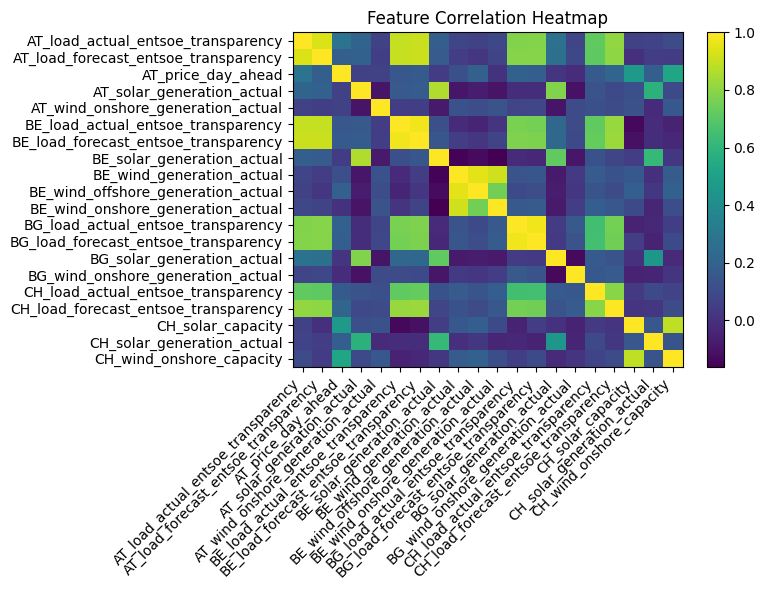

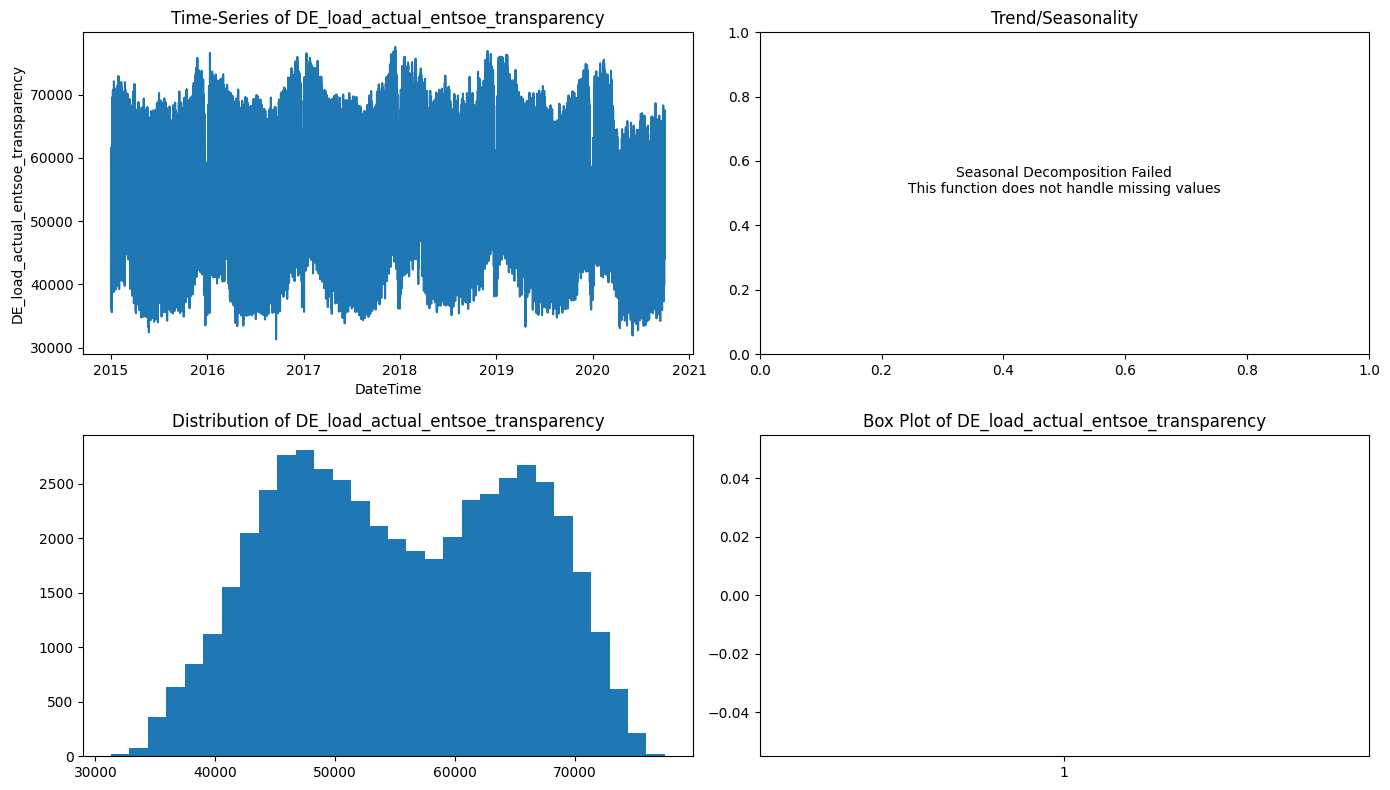

Selected 30 numeric features plus target using 'correlation' method.
df_corr_selected shape: (50393, 31)
Index(['AT_load_actual_entsoe_transparency',
       'AT_load_forecast_entsoe_transparency',
       'DE_tennet_load_actual_entsoe_transparency',
       'DE_transnetbw_load_forecast_entsoe_transparency',
       'LV_load_actual_entsoe_transparency',
       'PL_load_forecast_entsoe_transparency',
       'DE_amprion_load_actual_entsoe_transparency',
       'DE_50hertz_load_actual_entsoe_transparency',
       'DK_2_load_forecast_entsoe_transparency',
       'PL_load_actual_entsoe_transparency',
       'BE_load_forecast_entsoe_transparency',
       'CZ_load_actual_entsoe_transparency',
       'DE_amprion_load_forecast_entsoe_transparency',
       'DK_load_forecast_entsoe_transparency',
       'DE_tennet_load_forecast_entsoe_transparency',
       'HU_load_forecast_entsoe_transparency',
       'DK_load_actual_entsoe_transparency',
       'SI_load_forecast_entsoe_transparency',
       'DE_LU_

In [134]:
if __name__ == "__main__":
    # 1. Load data
    df_raw = load_data("/content/time_series_60min_singleindex.csv")

    # 2. Clean data (missing values)
    df_clean = clean_data(df_raw)

    # 3. Wavelet Denoising
    df_denoised = denoise_data(df_clean, wavelet='db4', level=1)

    # 4. Feature engineering: time-based
    df_feat = add_time_features(df_denoised)

    # 5. Correlation Heatmap with a subset of columns
    subset_cols_for_heatmap = df_feat.columns[:20]
    plot_correlation_heatmap(df_feat, columns_to_plot=subset_cols_for_heatmap)

    # 6. Advanced Visualization
    advanced_visualization(df_feat, column='DE_load_actual_entsoe_transparency')

    # 7. Feature selection using different methods
    # Example usage: correlation-based
    df_corr_selected = select_relevant_features(
        df_feat,
        target_col='DE_load_actual_entsoe_transparency',
        method='correlation',
        corr_threshold=0.2,
        top_k=30
    )
    print("df_corr_selected shape:", df_corr_selected.shape)
    print(df_corr_selected.columns)

    # Example usage: random forest-based
    # df_rf_selected = select_relevant_features(
    #     df_feat,
    #     target_col='DE_load_actual_entsoe_transparency',
    #     method='random_forest',
    #     top_k=30,
    #     random_forest_n_estimators=50
    # )
    # print("df_rf_selected shape:", df_rf_selected.shape)

    # Example usage: PCA-based (reduce dimension to 10 principal components)
    df_pca = select_relevant_features(
        df_feat,
        target_col='DE_load_actual_entsoe_transparency',
        method='pca',
        pca_components=10
    )
    print("df_pca shape:", df_pca.shape)
    print(df_pca.columns)

    # # Example usage: hybrid method
    # df_hybrid_selected = select_relevant_features(
    #     df_feat,
    #     target_col='DE_load_actual_entsoe_transparency',
    #     method='hybrid',
    #     corr_threshold=0.2,
    #     top_k=30,
    #     random_forest_n_estimators=50
    # )
    # print("df_hybrid_selected shape:", df_hybrid_selected.shape)
    # print(df_hybrid_selected.columns)

    # 8. Normalization (use correlation-based selection, for instance)
    features_to_scale = df_corr_selected.columns.tolist()
    df_norm, scaler = normalize_data(df_corr_selected, features_to_scale)

    train_end_date, val_end_date = find_time_split_dates(df_feat, train_ratio=0.7, val_ratio=0.2)

    # Time-based split
    train, val, test = time_based_split(df_feat, train_end_date, val_end_date)

    # 10. Sequence creation for LSTM/GRU/TFT
    target_col_index = df_norm.columns.get_loc('DE_load_actual_entsoe_transparency')
    X_train, y_train = create_sequences(train, target_col_index, seq_length=24, pred_length=1)
    X_val, y_val = create_sequences(val, target_col_index, seq_length=24, pred_length=1)
    X_test, y_test = create_sequences(test, target_col_index, seq_length=24, pred_length=1)

    print("Train sequences shape:", X_train.shape, y_train.shape)
    print("Validation sequences shape:", X_val.shape, y_val.shape)
    print("Test sequences shape:", X_test.shape, y_test.shape)